In [1]:
import monai 
from monai.transforms import (
    Compose,
    LoadImaged,
    RandCropByPosNegLabeld,
    EnsureChannelFirstd,
    ScaleIntensityd,
    Spacingd)
import nibabel
import tqdm
from torchmetrics import MeanSquaredError
import time
from monai.networks.nets import UNet
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, Dataset ,nifti_saver, PatchDataset, DataLoader, PersistentDataset
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob
from monai.networks.blocks import Convolution
from monai.utils import progress_bar
import torch.nn as nn
import torchmetrics 
from pytorchtools import EarlyStopping

/local/fogunsan.6797390.0/tmp/kslurm-venv-ntnjibta/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
date = "May23" # day we're getting models from
test_gad_t1= sorted(glob('/home/fogunsan/scratch/degad/derivatives/resampled/gad/*/*_acq-gad_resampled_T1w.nii.gz'))[42:47]# gad images who's corresponding nongad images underwent a rigid transform
test_nongad_t1= sorted(glob('/home/fogunsan/scratch/degad/derivatives/normalized_fcm/*/*_acq-nongad_normalized_fcm.nii.gz'))[42:47] # nongad images which underwent a rigid transform and underwent fcm normalization
test_files = [{"image": gad_name, "label": nongad_name} for gad_name, nongad_name in zip(test_gad_t1,test_nongad_t1)] #creates list of dictionaries, with gad and nongad images labelled



In [3]:
CNN=UNet(
            spatial_dims=3,
            in_channels=1,
            out_channels=1,
            channels=(16, 32,64,128,256,512,512,512),
            strides=(2, 2, 2, 2,1,1,1),
            dropout= 0.2,
        )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
CNN.apply(monai.networks.normal_init)
CNN_model = CNN.to(device)

In [4]:
CNN_model.load_state_dict(torch.load(f'/home/fogunsan/scratch/degad/derivatives/UNET/{date}/checkpoint.pt'))
CNN_model.eval()

UNet(
  (model): Sequential(
    (0): Convolution(
      (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (adn): ADN(
        (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (D): Dropout(p=0.2, inplace=False)
        (A): PReLU(num_parameters=1)
      )
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): Convolution(
          (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.2, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (1): SkipConnection(
          (submodule): Sequential(
            (0): Convolution(
              (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
              (adn): ADN(
                (N): Inst

In [6]:
inference_transforms = Compose( #loading full image
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityd(keys = ["image"], minv=0.0, maxv=1.0)])# applying min max normalization only on gad images
        

infer_ds = Dataset(data=test_files[2:], transform=inference_transforms) 
infer_loader = DataLoader(infer_ds, batch_size=1, shuffle=True) #using pytorch's dataloader




In [7]:

degad_imgs = []
gad_infer_imgs = []
nongad_infer_imgs = []
for infer_imgs in infer_loader:
    gad_infer_imgs.append(infer_imgs["image"])
    nongad_infer_imgs.append(infer_imgs["label"])
    output_degad_img = sliding_window_inference(inputs = infer_imgs["image"].to('cpu'), roi_size = (32,32,32), sw_batch_size= 5, predictor = CNN_model.to('cuda'), overlap = 0.25, mode = "gaussian", sw_device= 'cuda', device = 'cpu', progress = True )
    
    degad_imgs.append(output_degad_img)

100%|██████████| 194/194 [00:35<00:00,  5.48it/s]


In [8]:
for i in range(len(degad_imgs)): #looping thru number of output files
    degad_img =degad_imgs[i][0][0] # reshaping to exclude batch and channels (only one channel)
    gad_image= nibabel.load(test_files[i]["image"]) # getting original gad image back to compare to 
    gad_image_file = test_files[i]["image"]
    print(gad_image_file)
    sub = os.path.basename(gad_image_file).split("_")[0]
    degad_name = f'{sub}_acq-degad_T1w.nii.gz'
    degad_file = nibabel.Nifti1Image(degad_img.detach().numpy(), affine= None,header= gad_image.header) # with same header as inference gad 
    output_dir = f'/home/fogunsan/scratch/degad/derivatives/UNET/May23/degad_outputs'
    os.makedirs(f'{output_dir}/bids/{sub}/ses-pre/anat', exist_ok=True)# save in bids format
    output_path = f'{output_dir}/bids/{sub}/ses-pre/anat/{degad_name}'
    nibabel.save(degad_file,output_path) 

/home/fogunsan/scratch/degad/derivatives/resampled/gad/sub-P051/sub-P051_acq-gad_resampled_T1w.nii.gz
/home/fogunsan/scratch/degad/derivatives/resampled/gad/sub-P052/sub-P052_acq-gad_resampled_T1w.nii.gz
/home/fogunsan/scratch/degad/derivatives/resampled/gad/sub-P053/sub-P053_acq-gad_resampled_T1w.nii.gz


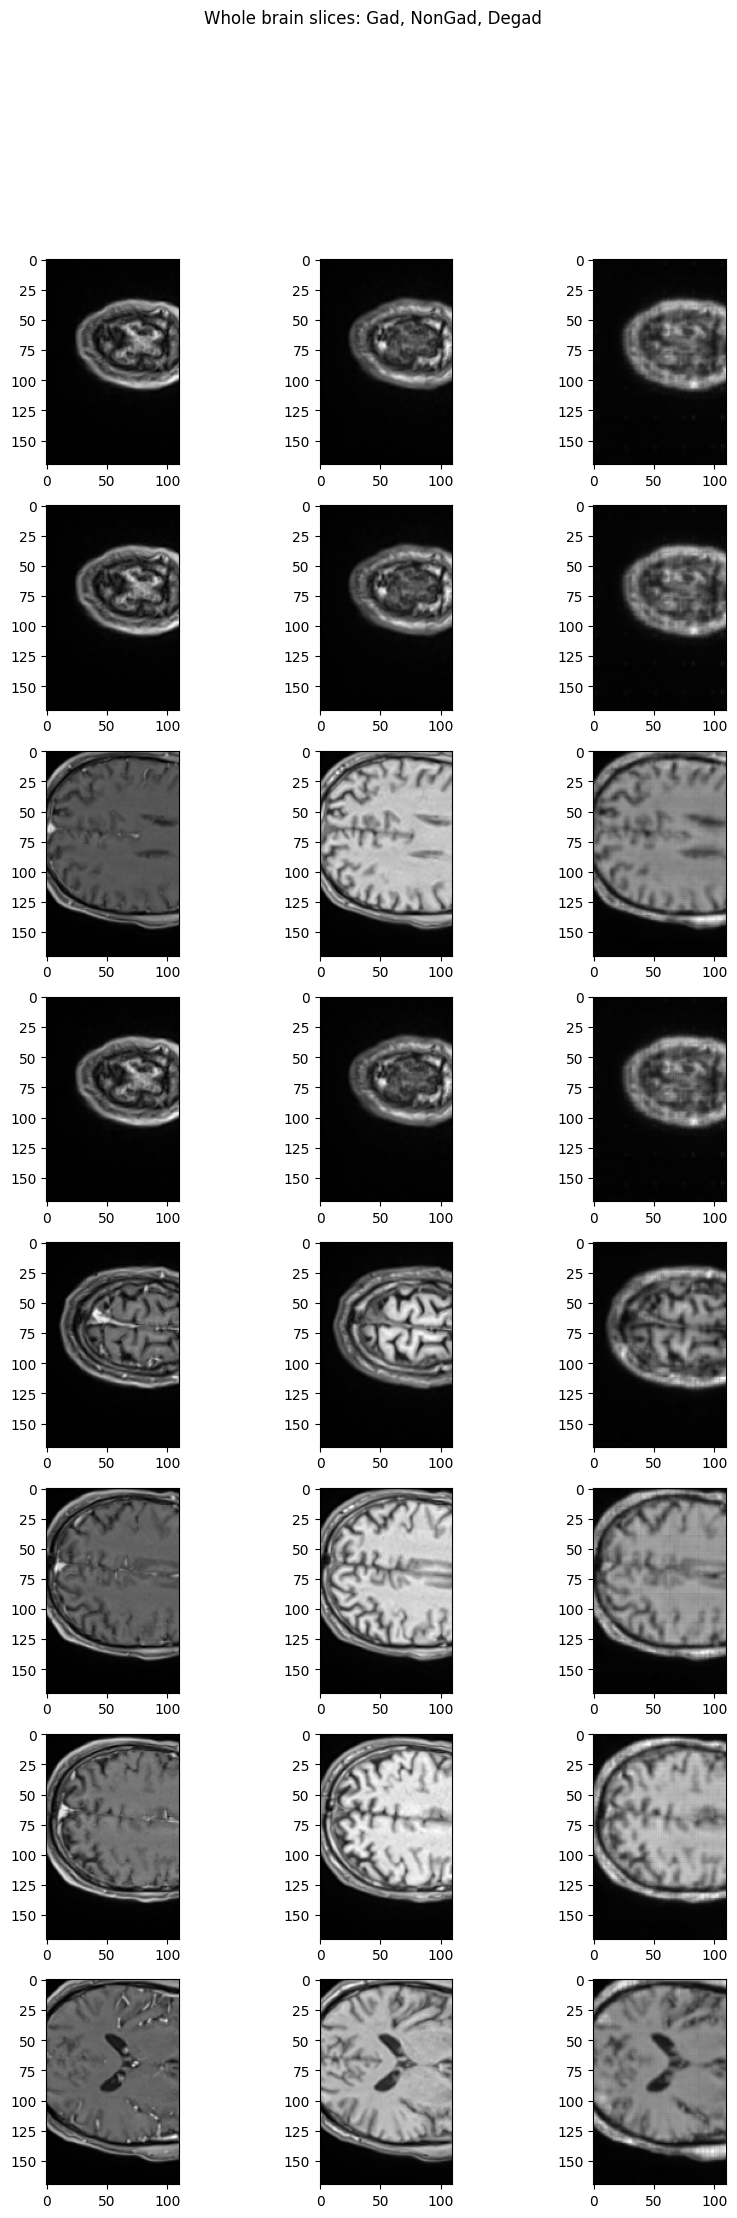

In [9]:
import random
## generating random whole brain slices
fig, axes = plt.subplots(8, 3,figsize=(10,25))
plt.suptitle('Whole brain slices: Gad, NonGad, Degad')

for i in range (1,25,3):
    plt.subplot(8, 3, i)
    x = random.randint(80, 190)
    plt.imshow(gad_infer_imgs[0][0, 0,40:210 ,40:150, x].cpu().data.numpy(), cmap ="gray")
    
    plt.subplot(8, 3, i+1)
    plt.imshow(nongad_infer_imgs[0][0, 0, 40:210 , 40:150, x].cpu().data.numpy(), "gray")
    
    plt.subplot(8, 3, i+2)
    plt.imshow(degad_imgs[0][0, 0, 40:210,40:150, x].cpu().data.numpy(), "gray")

plt.savefig(f'/home/fogunsan/scratch/degad/derivatives/UNET/{date}/degad_outputs/figure_whole_brain.png')
   

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


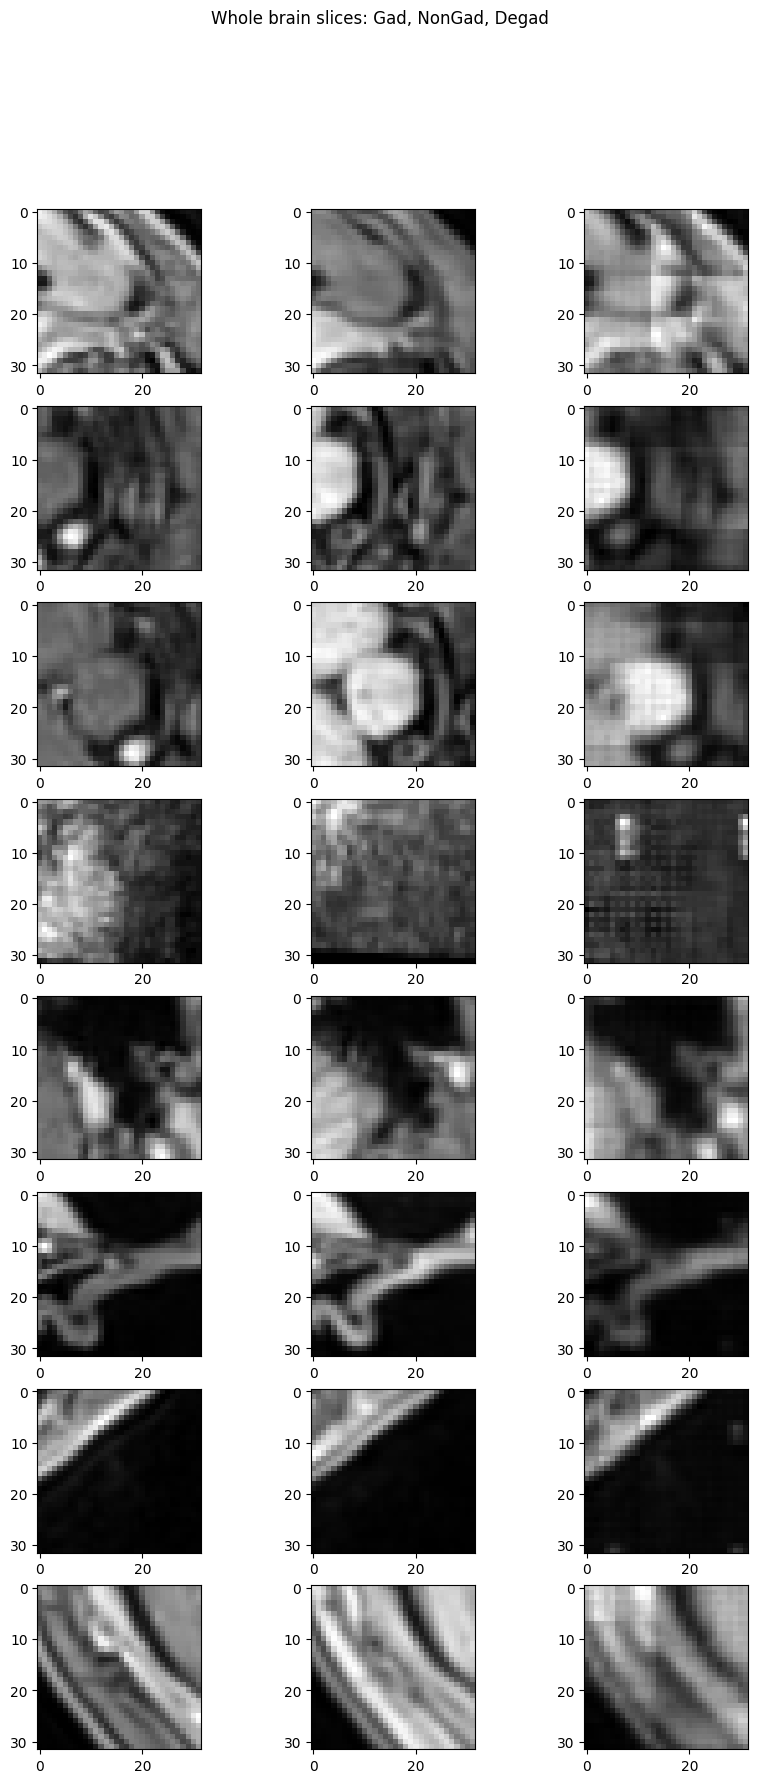

In [10]:
#generating random 32x32 slices
fig, axes = plt.subplots(8, 4,figsize=(10,20))
plt.suptitle('Whole brain slices: Gad, NonGad, Degad')

for i in range (1,25,3):
    
    x = random.randint(40, 190)
    y = random.randint(40, 190)
    z = random.randint(40, 190)
    plt.subplot(8, 3, i)
    plt.imshow(gad_infer_imgs[0][0, 0, x:x+32,y:y+32 ,50].cpu().data.numpy(), cmap ="gray")
    plt.subplot(8, 3, i+1)
    plt.imshow(nongad_infer_imgs[0][0, 0, x:x+32,y:y+32 ,50].cpu().data.numpy(), "gray")
    plt.subplot(8, 3, i+2)
    plt.imshow(degad_imgs[0][0, 0, x:x+32,y:y+32,50].cpu().data.numpy(), "gray")
   

plt.savefig(f'/home/fogunsan/scratch/degad/derivatives/UNET/{date}/degad_outputs/figure_32_patches.png')    